## 导入包和数据

In [450]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
from collections import Counter
from plotnine import *

from xgboost import plot_importance
from xgboost import XGBClassifier as XGBC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

sns.set_style("white")

In [452]:
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [15., 6.]

In [454]:
#读取数据
character_predictions = pd.read_csv("character-predictions.csv")
death_preds = character_predictions.copy(deep = True)
#print(character_predictions.dtypes)

## 数据预处理

In [456]:
# 文化族群映射字典
cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari', 'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
}

def get_cult(value, cult_dict):
    """根据文化族群映射字典重新命名文化族群"""
    value = value.lower()
    for key, values in cult_dict.items():
        if value in values:
            return key
    return value.title()

# 重新命名文化族群
death_preds['culture'] = death_preds['culture'].fillna("").apply(lambda x: get_cult(x, cult))

In [458]:
# 变量类型转换
columns_to_factorize = ["title", "culture", "mother", "father", "heir", "house", "spouse"]
for col in columns_to_factorize:
    death_preds[col] = pd.factorize(death_preds[col])[0]

# 去除不必要的列，重命名列名，填补缺失值
columns_to_drop = ["S.No", "alive", "plod", "pred",  "name", "title", "isAlive", "dateOfBirth","DateoFdeath"]
death_preds.drop(columns_to_drop, axis=1, inplace=True)
death_preds.columns = [col.replace(".", "").replace("_", "") for col in death_preds.columns]
death_preds.fillna(-1, inplace=True)

# 输出处理后的数据
print(death_preds.head())

#death_preds.to_csv('death_preds.csv', index=False)
#print("数据集已成功保存为CSV文件。")

   actual  male  culture  mother  father  heir  house  spouse  book1  book2  \
0       0     1        0       0       0     0     -1      -1      0      0   
1       1     1        1      -1      -1    -1      0       0      1      1   
2       1     1        0      -1      -1    -1      1      -1      0      0   
3       0     0        0      -1      -1    -1      2       1      0      0   
4       1     0        2      -1      -1    -1      3       2      0      0   

   ...  isAliveFather  isAliveHeir  isAliveSpouse  isMarried  isNoble   age  \
0  ...            0.0          0.0           -1.0          0        0  -1.0   
1  ...           -1.0         -1.0            1.0          1        1  97.0   
2  ...           -1.0         -1.0           -1.0          0        1  -1.0   
3  ...           -1.0         -1.0            0.0          1        1  23.0   
4  ...           -1.0         -1.0            1.0          1        1  29.0   

   numDeadRelations  boolDeadRelations  isPopular 

## 探索性数据分析

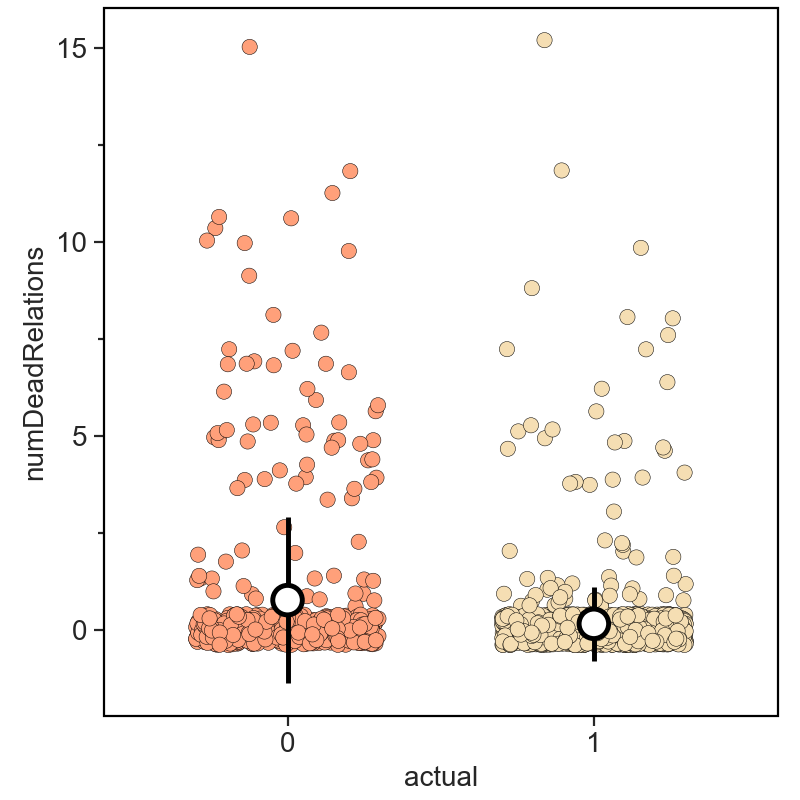

In [460]:
#带误差线的均值散点图
death_preds['actual'] = death_preds['actual'].astype('category')
(
    ggplot(death_preds, aes(x='actual', y="numDeadRelations", fill='actual'))
    + geom_jitter(width=0.3, size=3, stroke=0.1, show_legend=False)
    + stat_summary(fun_data="mean_sdl", fun_args={'mult': 1}, geom="pointrange", color="black", size=1, show_legend=False)
    + stat_summary(fun_data="mean_sdl", fun_args={'mult': 1}, geom="point", fill="w", color="black", size=5, stroke=1, show_legend=False)
    + scale_fill_manual(values=['#FFA07A', '#F5DEB3'])  # 设置自定义颜色
    + theme_matplotlib()
    + theme(aspect_ratio=1.05, dpi=100, figure_size=(4, 4))
)

In [464]:
# 计算每个角色在各部作品中的出场次数
books = ['book1', 'book2', 'book3', 'book4', 'book5']
death_preds['total_books'] = character_predictions[books].sum(axis=1)
death_preds['total_books'] 

0       0
1       5
2       1
3       0
4       1
       ..
1941    5
1942    3
1943    5
1944    3
1945    3
Name: total_books, Length: 1946, dtype: int64

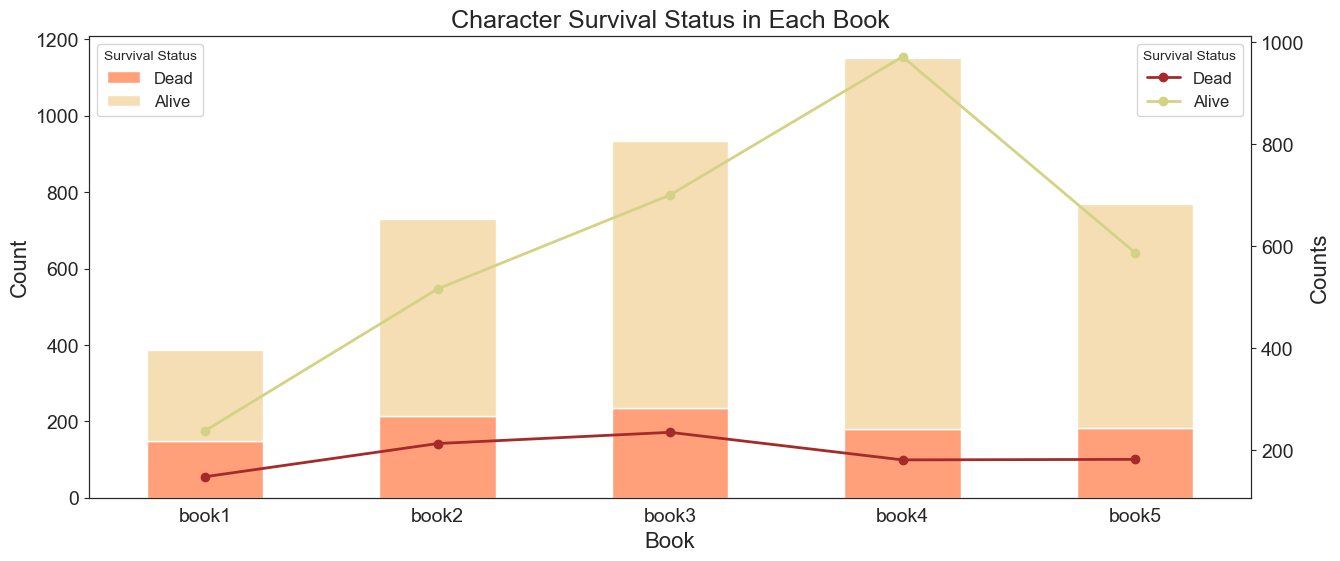

In [470]:
# 创建一个新的DataFrame来存储每个角色的出场情况和存活状态
data = []
for book in books:
    for index, row in death_preds.iterrows():
        if row[book] == 1:
            data.append([book, row['actual'], 1])
        else:
            data.append([book, row['actual'], 0])

# 将数据转换为DataFrame
book_df = pd.DataFrame(data, columns=['book', 'actual', 'presence'])

# 筛选出在书中出现的角色
appeared_df = book_df[book_df['presence'] == 1]

# 统计每部书中角色的死亡和存活情况
stats_df = appeared_df.groupby(['book', 'actual']).size().unstack(fill_value=0)

# 重命名列以更直观地表示存活状态
stats_df.columns = ['Dead', 'Alive']

# 绘制堆叠条形图
fig, ax1 = plt.subplots()
stats_df.plot(kind='bar', stacked=True, ax=ax1, color=['#FFA07A', '#F5DEB3'])
ax1.set_xlabel('Book')
ax1.set_ylabel('Count')
ax1.set_title('Character Survival Status in Each Book',fontsize=18)
ax1.legend(title='Survival Status', loc='upper left')
plt.xticks(rotation=0)

# 计算每部书的死亡和存活总数
dead_counts = stats_df['Dead']
alive_counts = stats_df['Alive']

# 创建第二个y轴用于折线图
ax2 = ax1.twinx()
ax2.plot(dead_counts.index, dead_counts, 'brown', marker='o', label='Dead', linewidth=2)
ax2.plot(alive_counts.index, alive_counts, color='#D3D385', marker='o', label='Alive', linewidth=2)
ax2.set_ylabel('Counts')
ax2.legend(title='Survival Status',loc='upper right')

plt.show()

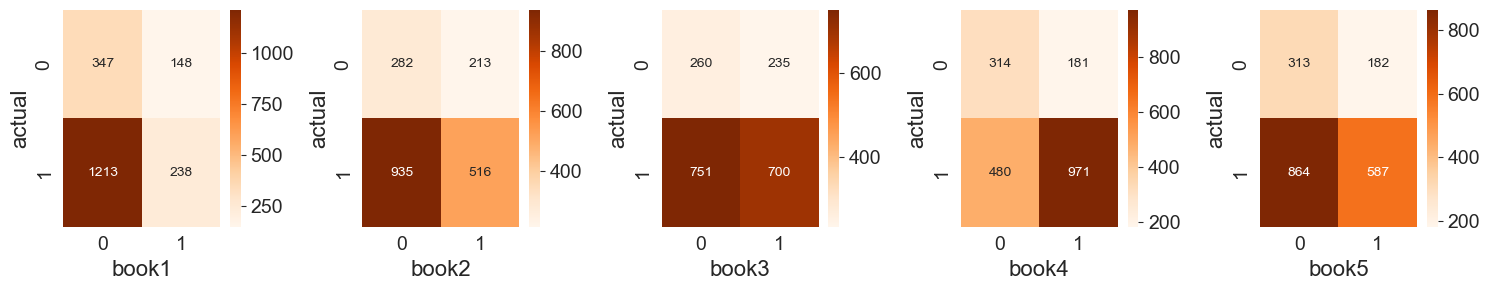

In [476]:
book_columns = ['book1', 'book2', 'book3', 'book4', 'book5']
f, ax = plt.subplots(1, 5, figsize=(15, 3))  # 创建一个1行5列的子图布局

# 遍历每个子图和书籍列
for a, col in zip(ax, book_columns):
    pivot_table = death_preds.pivot_table(index='actual', columns=col, aggfunc='size', fill_value=0, observed=False)
    # 绘制热力图
    sns.heatmap(pivot_table, annot=True, fmt="d", cmap='Oranges', ax=a)  # 使用正确的ax参数
   # a.set_title(f'Character Appearance in {col} by Survival Status')  # 为每个子图设置标题

plt.tight_layout()  # 调整子图间距
plt.show()  # 在循环外部显示所有子图

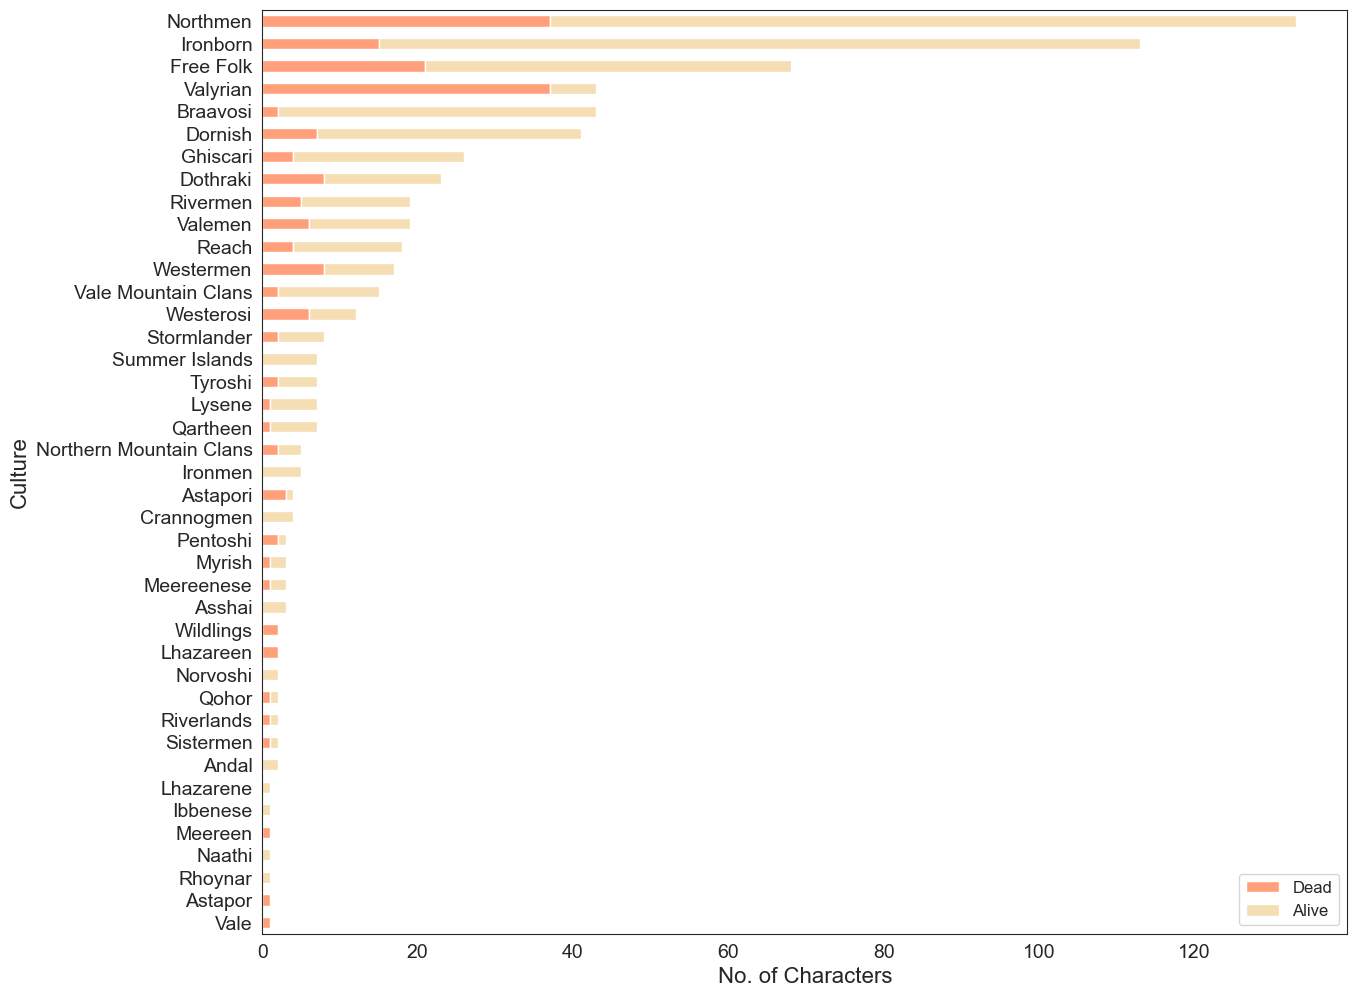

In [494]:
character_predictions.loc[:, "culture"] = [get_cult(x,cult) for x in character_predictions.culture.fillna("")]
#分组统计计算
data = character_predictions.groupby(["culture", "isAlive"]).count()["S.No"].unstack().copy(deep = True)
data.loc[:, "total"]= data.sum(axis = 1)
p = data[data.index != ""].sort_values("total")[[0, 1]].plot.barh(stacked = True, rot = 0, figsize = (14, 12),color=['#FFA07A', '#F5DEB3'])
_ = p.set(xlabel = "No. of Characters", ylabel = "Culture"), p.legend(["Dead", "Alive"], loc = "lower right")

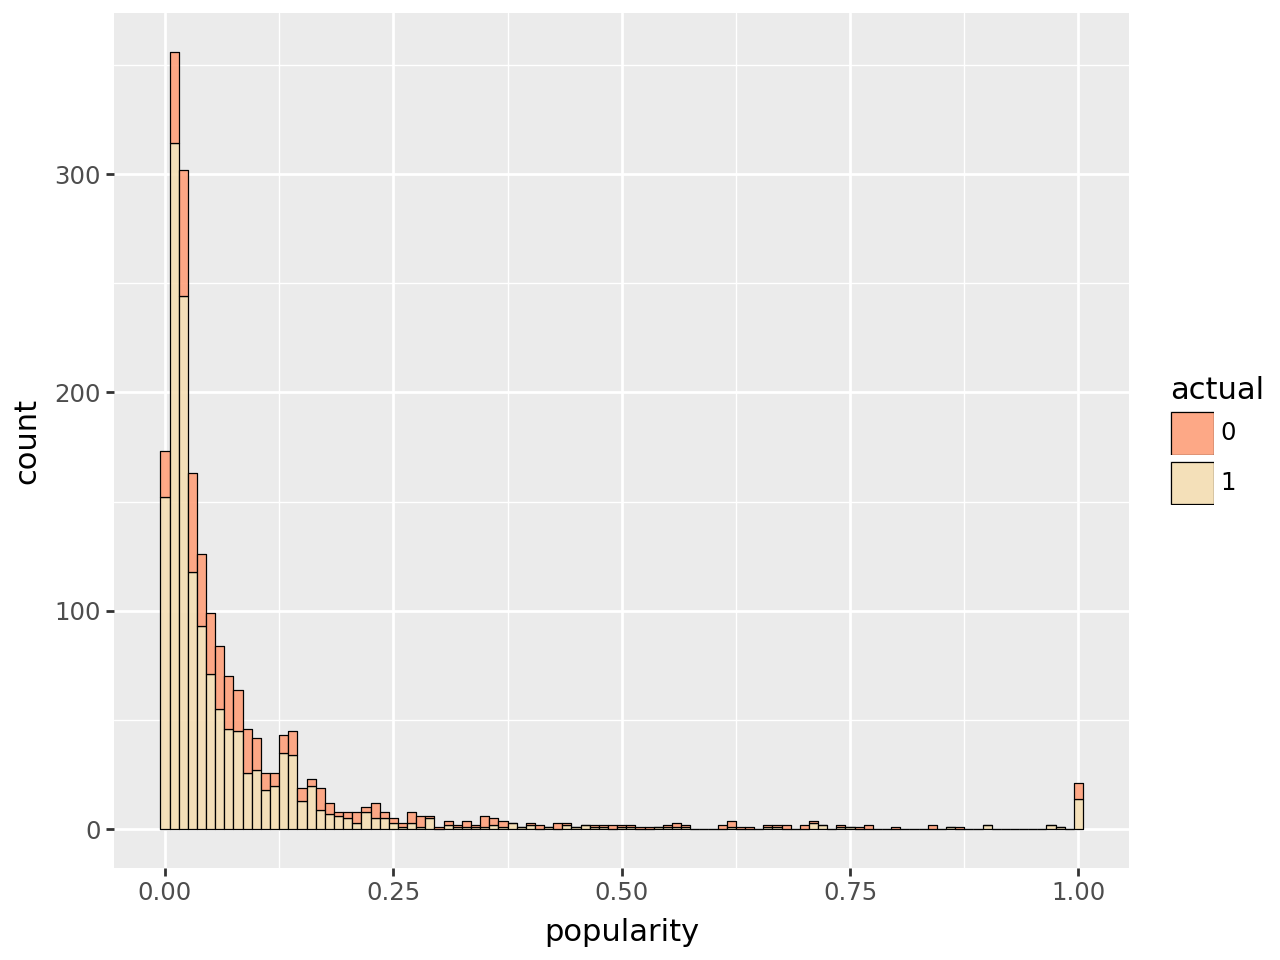

In [486]:
(
    ggplot(death_preds, aes(x='popularity', fill='actual'))
    + geom_histogram(binwidth=0.01, alpha=0.9, color='k', size=0.25)
    + scale_fill_manual(values=['#FFA07A', '#F5DEB3']) 
)

## 建模分析

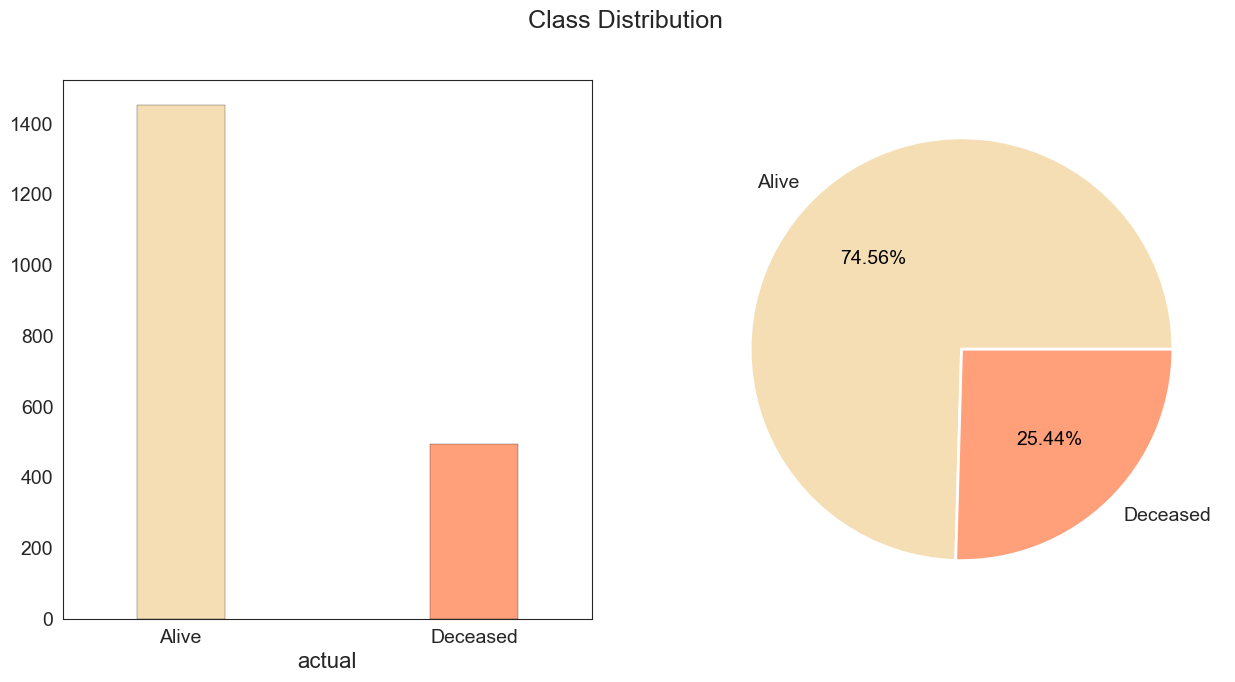

In [412]:
f, ax = plt.subplots(1, 2, figsize = (15, 7))
f.suptitle("Class Distribution", fontsize = 18.)
_ = death_preds.actual.value_counts().plot.bar(ax = ax[0], rot = 0, color = ( '#F5DEB3','#FFA07A',),edgecolor='k',width=0.3,linewidth=0.2).set(xticklabels = ["Alive", "Deceased"])
_ = death_preds.actual.value_counts().plot.pie(labels = ("Alive", "Deceased"), autopct = "%.2f%%", label = "", fontsize = 14., ax = ax[1],\
colors = ( '#F5DEB3','#FFA07A'), wedgeprops = {"linewidth": 2, "edgecolor": "w"}), ax[1].texts[1].set_color('k'), ax[1].texts[3].set_color('k')

In [258]:
class ModelTrainer:
    def __init__(self, data, target_column, test_size=0.2, random_state=1):
        self.data = data
        self.target_column = target_column
        self.test_size = test_size
        self.random_state = random_state
        self.X_train, self.X_test, self.y_train, self.y_test = self._prepare_data()

    def _prepare_data(self):
        try:
            # 分离特征和目标
            X = self.data.drop(self.target_column, axis=1)
            y = self.data[self.target_column]

            # 使用train_test_split进行划分，保持类别比例
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, stratify=y, random_state=self.random_state)

            # 欠采样
            rus = RandomUnderSampler(random_state=self.random_state)
            X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

            return X_train_under, X_test, y_train_under, y_test
        except Exception as e:
            print(f"Error preparing data: {e}")
            raise

    def train_model(self, model, params=None):
        try:
            if params:
                # 创建管道，先进行标准化，然后应用模型
                if isinstance(model, LogisticRegression):
                    pipe = Pipeline([
                        ('scaler', StandardScaler()),
                        ('logreg', model)
                    ])
                    # 调参过程
                    grid_search = GridSearchCV(pipe, params, cv=5, scoring='roc_auc')
                else:
                    grid_search = GridSearchCV(model, params, cv=5, scoring='roc_auc')
                grid_search.fit(self.X_train, self.y_train)
                best_model = grid_search.best_estimator_
                print(f"Best parameters: {grid_search.best_params_}")
            else:
                # 如果没有参数网格，直接训练模型
                if isinstance(model, LogisticRegression):
                    pipe = Pipeline([
                        ('scaler', StandardScaler()),
                        ('logreg', model)
                    ])
                    best_model = pipe.fit(self.X_train, self.y_train)
                else:
                    best_model = model.fit(self.X_train, self.y_train)

            return best_model
        except Exception as e:
            print(f"Error training model: {e}")
            raise

    def evaluate_model_metrics(self, model, model_name):
        try:
            preds = model.predict_proba(self.X_test)
            preds_class = np.argmax(preds, axis=1)

            # 打印性能报告
            print(f"{model_name} Performance\n" + "=" * (len(model_name) + 11) + "\n", classification_report(self.y_test, preds_class, target_names=["Deceased", "Alive"]))
            print("AUC      : %.4f" % roc_auc_score(self.y_test, preds[:, 1]))
            print("Accuracy : %.4f" % accuracy_score(self.y_test, preds_class))
            print("Log Loss : %.4f\n\n" % log_loss(self.y_test, preds[:, 1]))
        except Exception as e:
            print(f"Error evaluating model metrics: {e}")
            raise

    def plot_roc_curve(self, model, model_name):
        try:
            preds = model.predict_proba(self.X_test)
            fpr, tpr, _ = roc_curve(self.y_test, preds[:, 1])
            plt.figure(figsize=(8, 8))
            plt.plot(fpr, tpr, label=model_name)
            plt.plot((0., 1.), (0., 1.), "--k", alpha=.7)
            plt.legend(loc="upper left")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curves", fontsize=16)
            plt.show()
        except Exception as e:
            print(f"Error plotting ROC curve: {e}")
            raise

    def plot_confusion_matrix(self, model, model_name):
        try:
            plt.figure(figsize=(8, 8))
            preds = model.predict_proba(self.X_test)
            cm = confusion_matrix(self.y_test, np.argmax(preds, axis=1))
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            sns.heatmap(cm, square=True, xticklabels=["Deceased", "Alive"], annot=True,
                        annot_kws={"fontsize": 13}, yticklabels=["Deceased", "Alive"],
                        cbar=True, cbar_kws={"orientation": "horizontal"}, cmap="Oranges")
            plt.xlabel("Predicted Class")
            plt.ylabel("Actual Class")
            plt.title(f"Normalized Confusion Matrix - {model_name}",fontsize=18)
            plt.show()
        except Exception as e:
            print(f"Error plotting confusion matrix: {e}")
            raise

    def plot_roc_curve_comparison(self, models, model_names):
        try:
            plt.figure(figsize=(8, 8))
            for model, model_name in zip(models, model_names):
                preds = model.predict_proba(self.X_test)
                fpr, tpr, _ = roc_curve(self.y_test, preds[:, 1])
                plt.plot(fpr, tpr, label=model_name)
            plt.plot((0., 1.), (0., 1.), "--k", alpha=.7)
            plt.legend(loc="upper left")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve Comparison", fontsize=16)
            plt.show()
        except Exception as e:
            print(f"Error plotting ROC curve comparison: {e}")
            raise

    def plot_confusion_matrix_comparison(self, models, model_names):
        try:
            fig, axes = plt.subplots(1, len(models), figsize=(15, 8))
            fig.suptitle("Normalized Confusion Matrices", fontsize=18)
            for ax, model, model_name in zip(axes, models, model_names):
                preds = model.predict_proba(self.X_test)
                cm = confusion_matrix(self.y_test, np.argmax(preds, axis=1))
                cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                sns.heatmap(cm, square=True, xticklabels=["Deceased", "Alive"], annot=True,
                            annot_kws={"fontsize": 16}, yticklabels=["Deceased", "Alive"],
                            cbar=True, cbar_kws={"orientation": "horizontal"}, cmap="Oranges", ax=ax,vmin=0.25,vmax=0.75)
                ax.set_title(f"{model_name}")
                ax.set_xlabel("Predicted Class")
                ax.set_ylabel("Actual Class")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting confusion matrix comparison: {e}")
            raise

Best parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 14, 'subsample': 0.7}
XGB Classifier Performance
               precision    recall  f1-score   support

    Deceased       0.46      0.74      0.57        99
       Alive       0.89      0.71      0.79       291

    accuracy                           0.72       390
   macro avg       0.68      0.72      0.68       390
weighted avg       0.78      0.72      0.73       390

AUC      : 0.8152
Accuracy : 0.7179
Log Loss : 0.5603




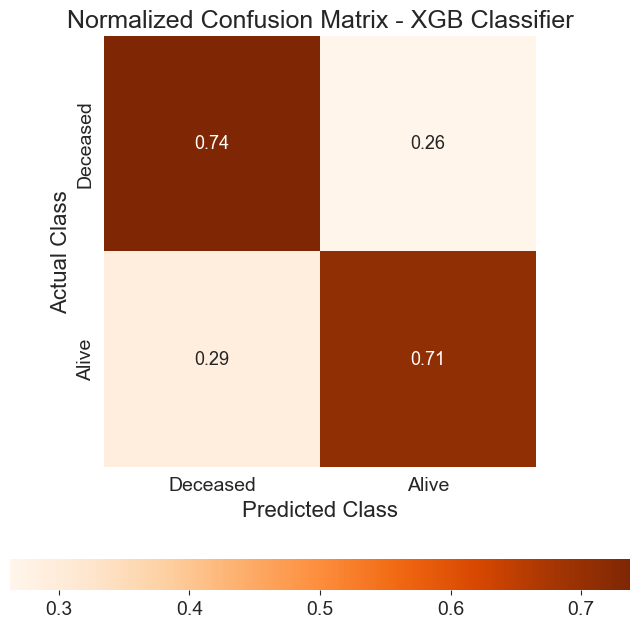

In [260]:
# 使用类
# death_preds是数据集
trainer = ModelTrainer(death_preds, 'actual')

# XGBoost 分类器
xgb_params = {
    'learning_rate':  [0.05],  
    'n_estimators': [50], 
    'max_depth': [3],
    'min_child_weight': [1],
    'gamma': [0.2], 
    'subsample': [0.7],
    'colsample_bytree':[0.9],
    'reg_alpha':[0],
    'reg_lambda':[0],
    'seed': [14]
}
xgb_model = trainer.train_model(XGBC(), xgb_params)
# 评估模型
trainer.evaluate_model_metrics(xgb_model, "XGB Classifier")
trainer.plot_confusion_matrix(xgb_model, "XGB Classifier")

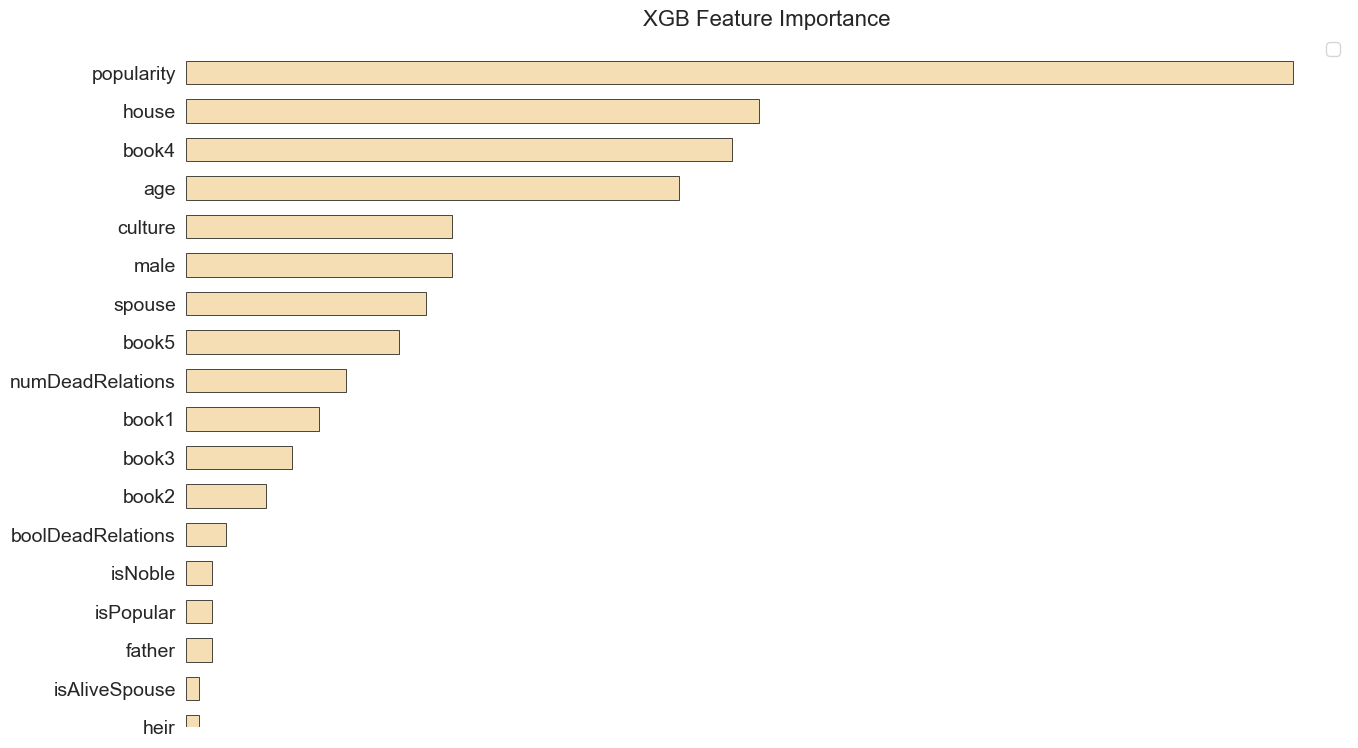

In [262]:
# 绘制特征重要性图
ax = pd.DataFrame(list(xgb_model.get_booster().get_fscore().items()), columns=['Feature', 'Importance']).set_index('Feature')\
    .sort_values('Importance').plot.barh(width=0.6,figsize=(15, 9),color='#F5DEB3', edgecolor='black', linewidth=0.5)
ax.set(frame_on=False, ylim=(0, len(xgb_model.get_booster().get_fscore())), xticklabels="", xlabel="", ylabel="")
ax.legend("")
plt.title("XGB Feature Importance", fontsize=16)
plt.show()

E:\ANACONDA\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


Best parameters: {'logreg__C': 0.1, 'logreg__solver': 'lbfgs'}
Logistic Regression Performance
               precision    recall  f1-score   support

    Deceased       0.37      0.64      0.47        99
       Alive       0.84      0.64      0.72       291

    accuracy                           0.64       390
   macro avg       0.60      0.64      0.60       390
weighted avg       0.72      0.64      0.66       390

AUC      : 0.7126
Accuracy : 0.6359
Log Loss : 0.6244




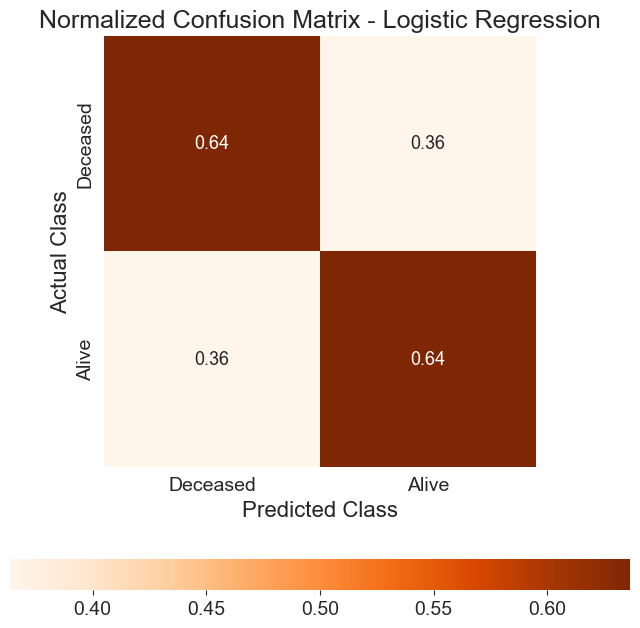

In [264]:
# 逻辑回归模型
lr_params = {
    'logreg__C': [0.01,0.1,1,3,4,5,10],
    'logreg__solver': ['lbfgs','saga','liblinear','newton-cg']
}
lr_model = trainer.train_model(LogisticRegression(max_iter=1000), lr_params)
trainer.evaluate_model_metrics(lr_model, "Logistic Regression")
trainer.plot_confusion_matrix(lr_model, "Logistic Regression")

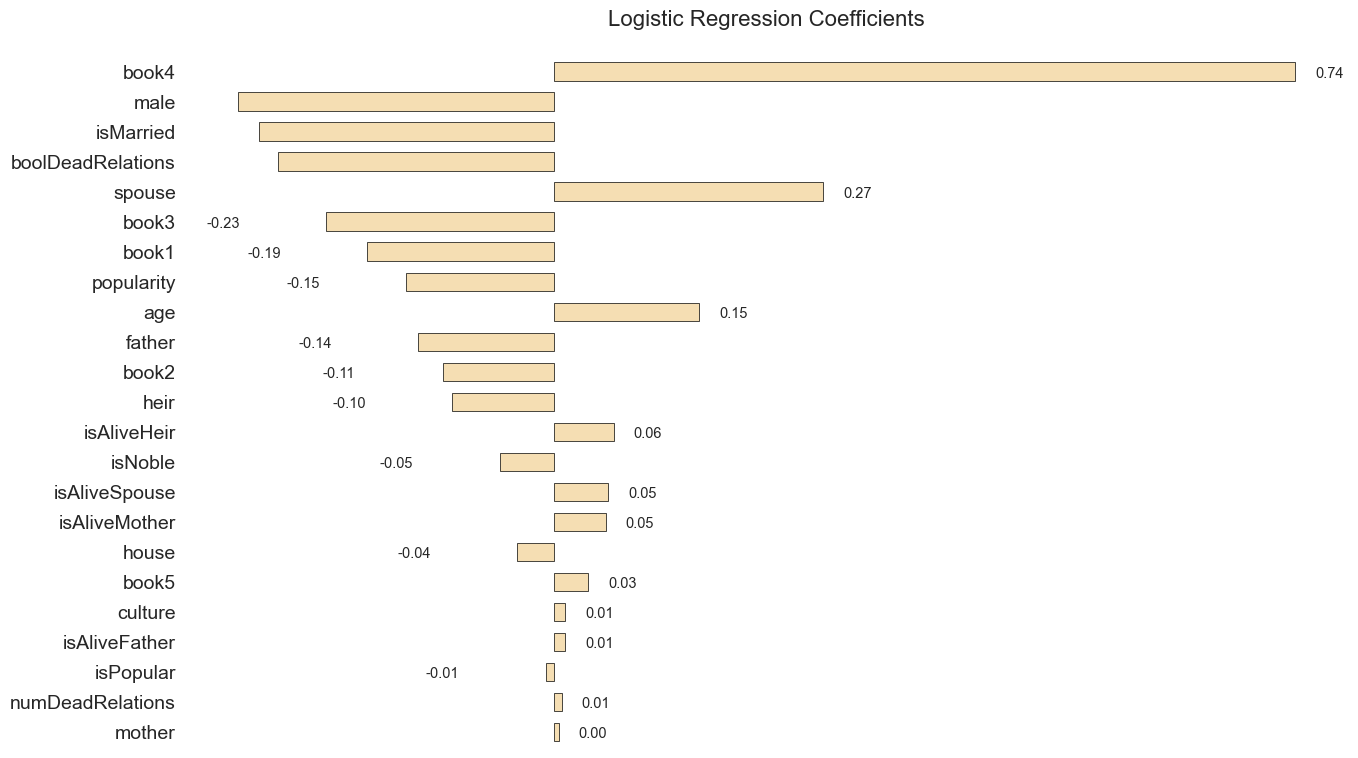

In [266]:
# 绘制系数条形图
# 准备系数数据
# 访问管道中的逻辑回归模型的系数
lr_model_coef = lr_model.named_steps['logreg'].coef_[0]
df = pd.DataFrame(list(zip(trainer.X_test.columns, lr_model_coef)), columns=['Feature', 'Coefficient'])
df = df.reindex(df['Coefficient'].abs().sort_values().index).set_index('Feature')
ax = df.plot.barh(width=0.6, legend="", figsize=(15, 9), color='#F5DEB3', edgecolor='black', linewidth=0.5)
ax.set_title("Logistic Regression Coefficients", y=1.03, fontsize=16)
_ = ax.set(frame_on=False, xlabel="", xticklabels="", ylabel="")

# 添加系数值注释
for i, label in enumerate(list(df.index)):
    score = df.loc[label]['Coefficient']
    ax.annotate('%.2f' % score, (score + (-.12 if score < 0 else .02), i - .2), fontsize=10.5)

plt.show()

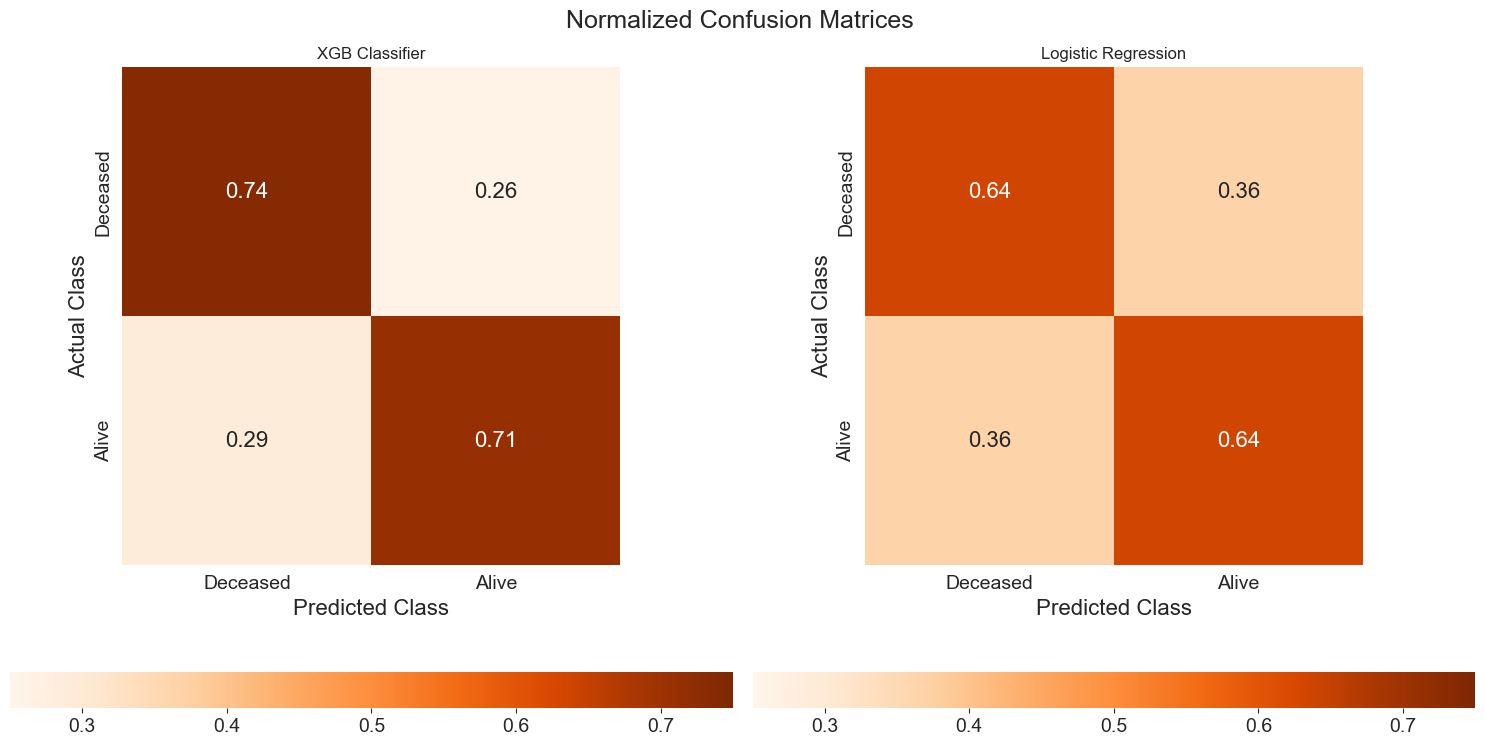

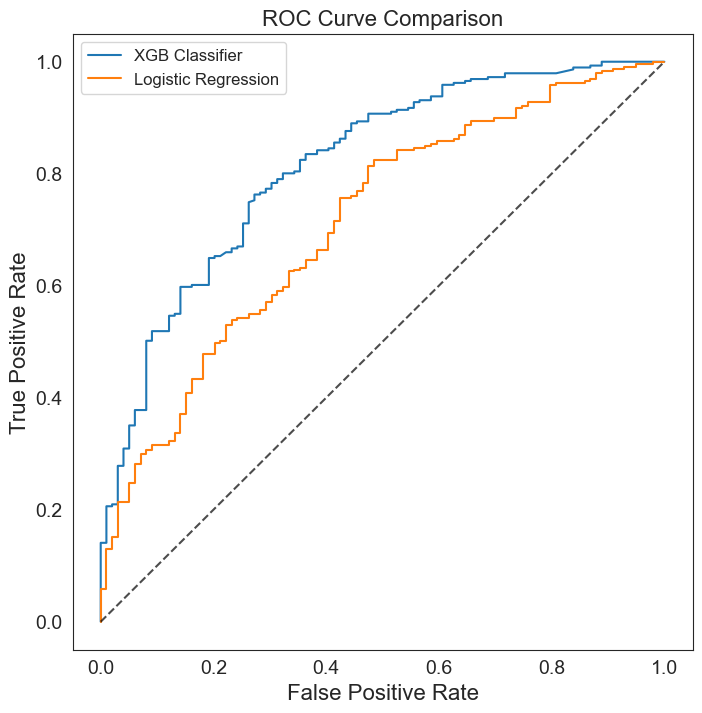

In [268]:
# 绘制混淆矩阵对比
trainer.plot_confusion_matrix_comparison([xgb_model, lr_model], ["XGB Classifier", "Logistic Regression"])
# 绘制ROC曲线对比
trainer.plot_roc_curve_comparison([xgb_model, lr_model], ["XGB Classifier", "Logistic Regression"])